In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import pandas as pd
from sklearn.preprocessing import scale
from scipy.spatial.transform import Rotation as R

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

In [ ]:
gestures = ['arrow', 'check', 'caret']
data = []
labels = []

for root, subdirs, files in os.walk('dataset'):
    if 'ipynb_checkpoint' in root:
        continue
        
    if len(files) > 0:
        for f in files:
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                    
                xml_root = ET.parse(f'{root}/{f}').getroot()
                    
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                        
                points = np.array(points, dtype=float)
                    
                if not label in labels and label in gestures:
                    data.append((label, points))
                    labels.append(label)

                if len(labels) == len(gestures):
                    break

print(len(data), "files loaded successfully.")


In [3]:
def add_noise(sequence):
    noise = np.random.normal(0,0.8,sequence.shape)
    noise_seq = sequence + noise
    return noise_seq

In [4]:
def scaling(sequence):
    centroid = np.mean(sequence)
    rnd_x = np.random.uniform(0.8, 1.2)
    rnd_y = np.random.uniform(0.8, 1.2)
    points = sequence - centroid
    scaled_seq=[]
    for x, y in points:
        scaled_x = x*rnd_x
        scaled_y = y*rnd_y 
        scaled_seq.append([scaled_x,scaled_y])
    scaled_seq += centroid
    return scaled_seq

In [5]:
def spatial_resampling(sequence):
    resampled_seq = resample(sequence, np.random.randint(5, len(sequence)*2))
    return resampled_seq

In [6]:
def perspective_change(sequence):
    persp_seq = []
    centroid = np.mean(sequence)
    angle = np.random.uniform(-30, 30)
    r = R.from_euler('yx', [angle, angle], degrees=True)
    sequence = sequence - centroid
    for point in sequence:
        point=np.append(point, 1)
        new_point = np.array(r.as_matrix() @ point)
        persp_seq.append(new_point[:-1]) 
    persp_seq += centroid
    return persp_seq

In [7]:
def skip_frames(sequence):
    skipped_seq = []
    for point in sequence:
        if np.random.uniform(high=1.0) >= 0.3:
            skipped_seq.append(point)
    return np.asarray(skipped_seq)

In [8]:
def rotate(sequence):
    centroid = np.mean(sequence)
    points = sequence - centroid
    angle = np.random.randint(-20, high=20)
    r = R.from_euler('z', angle, degrees=True)
    mat = r.as_matrix()
    points_transformed = []
    for p in points:
        p = np.append(p, 1)
        result = np.array(mat @ p)
        result /= result[2]
        points_transformed.append(result[:-1])
    points_transformed += centroid
    return points_transformed

In [9]:
def avc_transformation(sequence):
    noise_seq = add_noise(sequence)
    skipped_seq = skip_frames(noise_seq)
    resampled_seq = spatial_resampling(skipped_seq)
    persp_seq = perspective_change(resampled_seq)
    rotated_seq = rotate(persp_seq)
    scaled_seq = scaling(rotated_seq)
    return scaled_seq

In [10]:
def simple_transformation(sequence):
        rotated_seq = rotate(sequence)
        scaled_seq = scaling(rotated_seq)
        gaussian_seq = add_noise(scaled_seq)
        return gaussian_seq

In [13]:
test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]

noise_seq = add_noise(sequence)
skipped_seq = skip_frames(sequence)
resampled_seq = spatial_resampling(sequence)
persp_seq = perspective_change(sequence)
rotated_seq = rotate(sequence)
scaled_seq = scaling(sequence)
avc_seq = avc_transformation(sequence)
simple_seq = simple_transformation(sequence)

/tmp/ipykernel_60193/90106140.py:55: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([orig, augm], labels=labels,


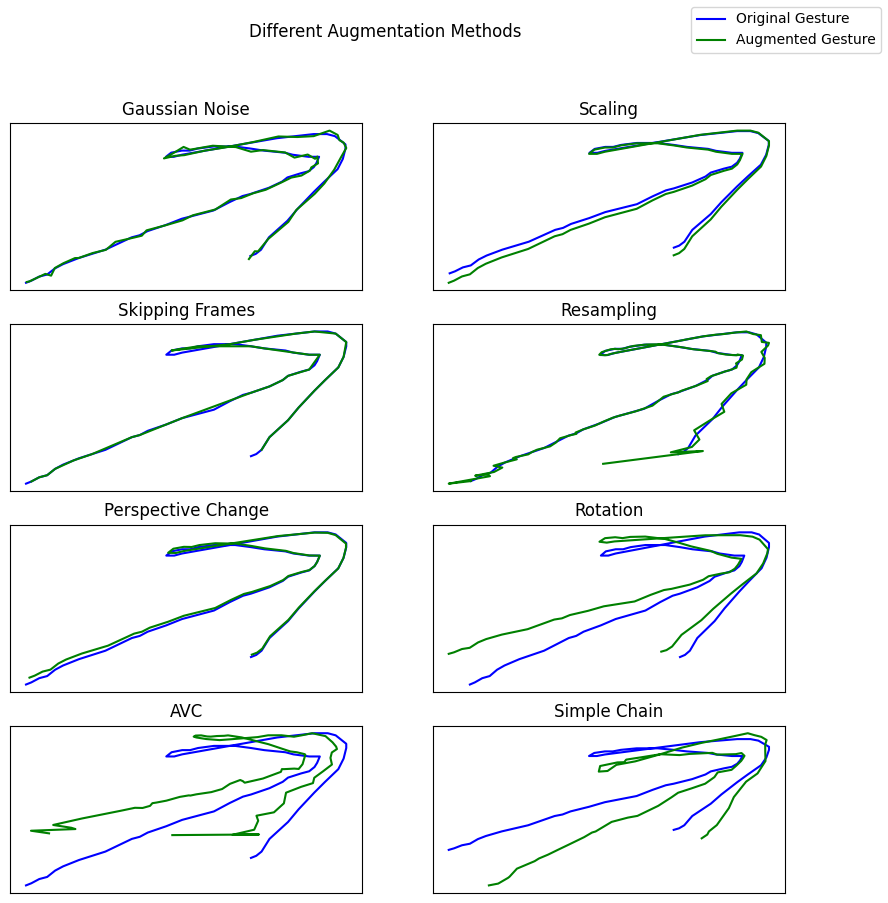

In [14]:

# Create four polar axes and access them through the returned array
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
axs[0, 0].plot(sequence.T[0], sequence.T[1]*-1, 'b')
axs[0, 0].plot(noise_seq.T[0], noise_seq.T[1]*-1, 'g')
axs[0, 0].set_title("Gaussian Noise")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

axs[0, 1].plot(sequence.T[0], sequence.T[1]*-1, 'b')
axs[0, 1].plot(scaled_seq.T[0], scaled_seq.T[1]*-1, 'g')
axs[0, 1].set_title("Scaling")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

axs[1, 0].plot(sequence.T[0], sequence.T[1]*-1, 'b')
axs[1, 0].plot(skipped_seq.T[0], skipped_seq.T[1]*-1, 'g')
axs[1, 0].set_title("Skipping Frames")
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

axs[1, 1].plot(sequence.T[0], sequence.T[1]*-1, 'b')
axs[1, 1].plot(resampled_seq.T[0], resampled_seq.T[1]*-1, 'g')
axs[1, 1].set_title("Resampling")
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

axs[2, 0].plot(sequence.T[0], sequence.T[1]*-1, 'b')
axs[2, 0].plot(persp_seq.T[0], persp_seq.T[1]*-1, 'g')
axs[2, 0].set_title("Perspective Change")
axs[2, 0].set_xticks([])
axs[2, 0].set_yticks([])

axs[2, 1].plot(sequence.T[0], sequence.T[1]*-1, 'b')
axs[2, 1].plot(rotated_seq.T[0], rotated_seq.T[1]*-1, 'g')
axs[2, 1].set_title("Rotation")
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])

orig = axs[3, 0].plot(sequence.T[0], sequence.T[1]*-1, 'b')
augm = axs[3, 0].plot(avc_seq.T[0], avc_seq.T[1]*-1, 'g')
axs[3, 0].set_title("AVC")
axs[3, 0].set_xticks([])
axs[3, 0].set_yticks([])

axs[3, 1].plot(sequence.T[0], sequence.T[1]*-1, 'b')
axs[3, 1].plot(simple_seq.T[0], simple_seq.T[1]*-1, 'g')
axs[3, 1].set_title("Simple Chain")
axs[3, 1].set_xticks([])
axs[3, 1].set_yticks([])


fig.suptitle("Different Augmentation Methods")

labels = ["Original Gesture", "Augmented Gesture"]
fig.legend([orig, augm], labels=labels,
           loc="upper right")